In [109]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_moons


In [110]:
# populate the dataset
X_moon, label= make_moons(n_samples= 1000, noise=0.2, random_state=42)
X_moon.shape, label.shape

((1000, 2), (1000,))

In [111]:
# Visualize with panda dataframe
df= pd.DataFrame({"X":X_moon[:,0], "Y": X_moon[:,1] ,"Label": label})
df.head()

,X,Y,Label
0,-0.111667,0.520224,1
1,1.142650,-0.342577,1
2,0.795558,-0.011442,1
3,0.111827,-0.551932,1
4,-0.816466,0.543996,0


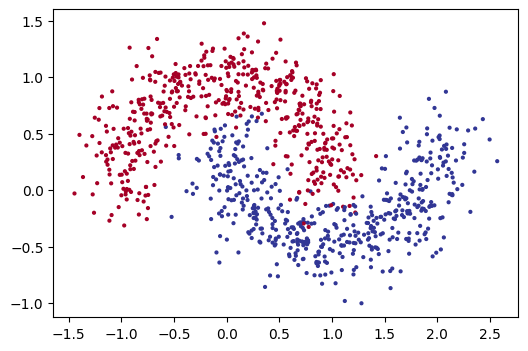

In [112]:
# Now lets visualize it by plotting

plt.figure(figsize=(6,4))
plt.scatter(X_moon[:,0], X_moon[:,1], c=label, cmap=plt.cm.RdYlBu, s=4 )

In [113]:
#First we need to convert it to tensor since it is in numpy currently
X_tensor= torch.from_numpy(X_moon).type(torch.float32)
X_tensor.shape, X_tensor.dtype

(torch.Size([1000, 2]), torch.float32)

In [114]:
label= torch.from_numpy(label).type(torch.float32)
label.dtype

torch.float32

In [115]:
# Now it is time to split our data
x_train, x_test, y_train, y_test= train_test_split(X_tensor, label, test_size=0.3, random_state=42)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([700, 2]),
 torch.Size([700]),
 torch.Size([300, 2]),
 torch.Size([300]))

In [116]:
# Creating our model class
class MoonClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1= nn.Linear(in_features=2, out_features=16)
        self.layer2= nn.Linear(in_features=16, out_features=8)
        self.layer3= nn.Linear(in_features=8, out_features=4)
        self.layer4= nn.Linear(in_features=4, out_features= 1)
        self.relu= nn.ReLU()
    
    def forward(self, x:torch.Tensor)-> torch.Tensor:
        rslt= self.layer1(x)
        rslt= self.relu(rslt)
        rslt= self.layer2(rslt)
        rslt= self.relu(rslt)
        rslt= self.layer3(rslt)
        rslt= self.relu(rslt)
        rslt= self.layer4(rslt)
        return rslt
  

In [117]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
torch.manual_seed(42)
model_moon= MoonClassifier()

lossFn= nn.BCEWithLogitsLoss()
optimizer= torch.optim.Adam(params=model_moon.parameters(), lr=0.0001)
epochs= 8000

acc_values=[]
prec_values= []
rcl_values=[]
f1scr_values=[]

epoch_values= []

for epoch in range(epochs):
    model_moon.train()
    y_train_logit= model_moon(x_train).squeeze()
    y_train_pred= torch.round(torch.sigmoid(y_train_logit))
    
    loss= lossFn(y_train_logit, y_train)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    if epoch % 50 == 0:
        model_moon.eval()
        epoch_values.append(epoch)
        with torch.inference_mode():
            y_test_logit= model_moon(x_test).squeeze()
            y_test_pred= torch.round(torch.sigmoid(y_test_logit))
            
            test_loss= lossFn(y_test_logit, y_test)
            
            acc= accuracy_score(y_test, y_test_pred.detach().numpy())
            prec= precision_score( y_test, y_test_pred.detach().numpy())
            recl= recall_score(y_test, y_test_pred.detach().numpy())
            f1scr= f1_score(y_test, y_test_pred)
            acc_values.append(acc)
            prec_values.append(prec)
            f1scr_values.append(f1scr)
            rcl_values.append(recl)
            
    


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

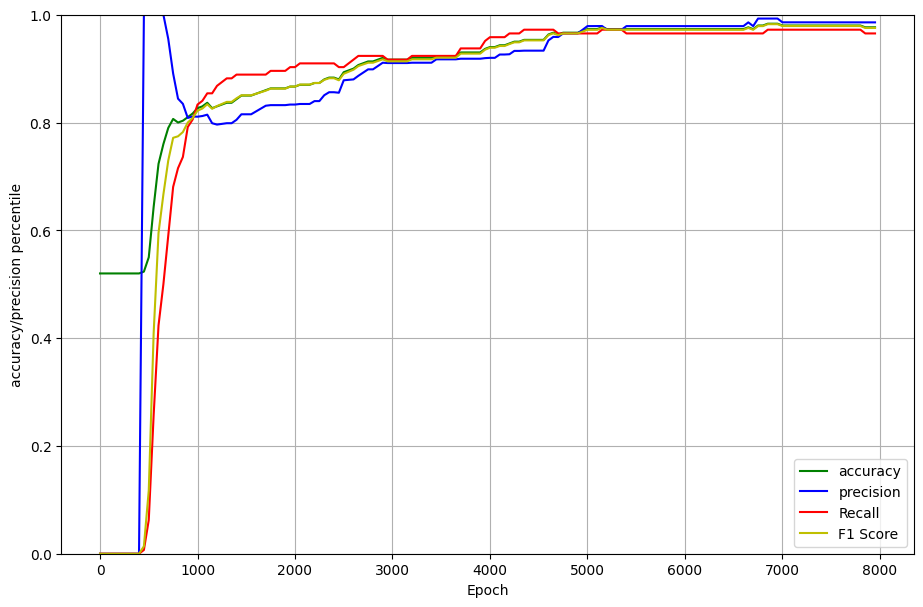

In [118]:
plt.figure(figsize=(11,7))
plt.plot(epoch_values, acc_values, c='g', label="accuracy")
plt.plot(epoch_values, prec_values, c='b', label="precision")
plt.plot(epoch_values, rcl_values, c='r', label="Recall" )
plt.plot(epoch_values, f1scr_values, c='y', label="F1 Score")
plt.xlabel("Epoch")
plt.ylabel("accuracy/precision percentile")
plt.ylim(0,1)
plt.grid(True)
plt.legend()

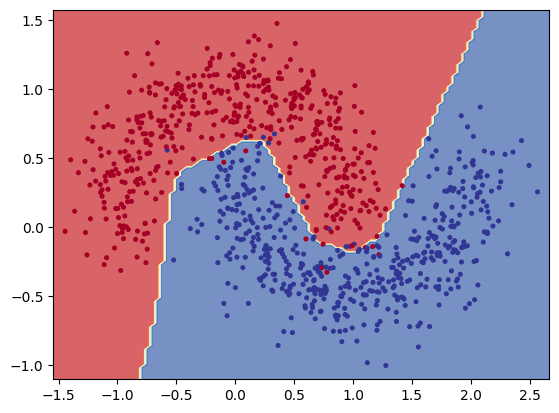

In [119]:
import numpy as np
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=7, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
plot_decision_boundary(model_moon, X_tensor, label)

In [120]:
with torch.inference_mode():
    model_moon.eval()
    logit= model_moon(x_test).squeeze()
    pred= torch.round(torch.sigmoid(logit))
    
    final_accuracy= accuracy_score(y_test, pred.detach().numpy())
    final_precision= precision_score(y_test, pred.detach().numpy())
    final_recall= recall_score(y_test, pred.detach().numpy())
    final_f1score= f1_score(y_test, pred.detach().numpy())
    conf= confusion_matrix(y_test, pred.detach().numpy())

print(f"Final Accuracy: {final_accuracy}")
print(f"Final Precision: {final_precision}")
print(f"Final Recall: {final_recall}")
print(f"Final F1 Score: {final_f1score}")
print(f"Confusion Matrix: {conf}")

Final Accuracy: 0.9766666666666667
Final Precision: 0.9858156028368794
Final Recall: 0.9652777777777778
Final F1 Score: 0.9754385964912281
Confusion Matrix: [[154   2]
 [  5 139]]


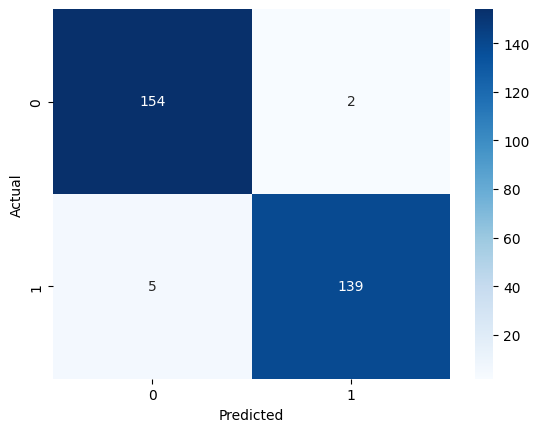

In [121]:
import seaborn as sns
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()